#A New dataset for hate speech detection on Facebook sentiment for Chadian Text

##Import packages and Libraries

In [1]:
#!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git

In [2]:
!python -m spacy download fr_core_news_md

     |████████████████████████████████| 88.6 MB 1.2 MB/s 
  Created wheel for fr-core-news-md: filename=fr_core_news_md-2.2.5-py3-none-any.whl size=90338488 sha256=d0a390e485085e8219548761da36d7e6fa7c17320e64f3817d6ef905b8a27199
  Stored in directory: /tmp/pip-ephem-wheel-cache-u0u56a6q/wheels/2e/26/ff/ce93eb966e7176ebe81e6c98209582e13e108cdd2d6d636df0
Successfully built fr-core-news-md
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


In [3]:
import nltk
nltk.download('all', quiet=True)

True

In [4]:
import spacy
import fr_core_news_md

In [5]:
import pandas as pd
import numpy as np
import re
import string
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import itertools
#import preprocess_kgptalkie as ps
import logging

In [6]:
from gensim.models import Word2Vec, FastText, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
####
from nltk import ngrams, bigrams
from nltk.stem import *
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize, WordNetLemmatizer
####
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
####
from spacy import displacy
from spacy.lang.fr.stop_words import STOP_WORDS as list_stop
from wordcloud import WordCloud, STOPWORDS
####
from time import time
from collections import defaultdict

stop_words = set(stopwords.words('french'))
plt.style.use('fivethirtyeight')

##Upload the datasets

In [7]:
#Load the train data
train_df=pd.read_csv('train_datasets.csv', encoding='latin')
#load the test data
test_df=pd.read_csv('test_datasets.csv', encoding ='latin')
train_df.head()

,id,query_type,message,Class,Label,Hate_Speech,Offensive_Language,Insult,Normal_Comment
0,8,Facebook:/<page-id>/posts,"?? Dr. Djiddi Ali Sougoudi : ""Pourquoi je regr...",normal,4,0,0,0,4
1,19,Facebook:/<page-id>/posts,"Dr. Djiddi Ali Sougoudi : ""Pourquoi je regrett...",offensive,2,0,2,0,0
2,23,Facebook:/<post-id>/comments,Walay inal abouk zata,hate,1,1,0,0,0
3,38,Facebook:/<post-id>/comments,Da bineye hana wene wa,normal,4,0,0,0,4
4,95,Facebook:/<post-id>/comments,Dehors guilital-adable,insult,3,0,0,3,0


In [8]:
test_df.head()

,id,comment
0,341,J'ai envie de dire à notre voisin que sa femme...
1,682,La viande de cheval est vendue à NDjamena don...
2,1835,Amine????????au pluriel aminerrrrrrrr wehhhh??...
3,2335,Amiss tchakkamna pini wa alyom moteur. Houmar ...
4,2336,Oui bonjour la famille Je ne jamais cru à Ndj...


In [9]:
#Rename Columns headers
train_df = train_df.rename(columns={"message": 'comment', "Hate_Speech": 'hate',"Offensive_Language": 'offensive',"Normal_Comment": 'Neutral',"Label": 'target'})

In [10]:
#Remove duplicate
train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)

In [11]:
#Nomber of comment per Label
train_df['target'].value_counts()

4    5006
2    1241
1     429
3     325
Name: target, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


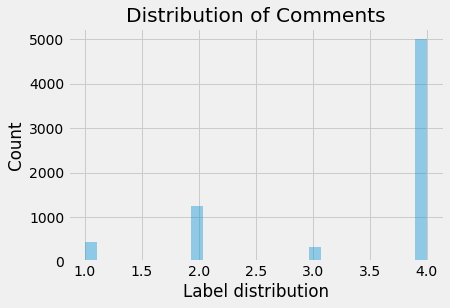

In [12]:
# Plot frequency of comments
fig = sns.distplot(train_df['target'], kde=False)
plt.xlabel("Label distribution")
plt.ylabel("Count")
plt.title("Distribution of Comments")
plt.show(fig)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


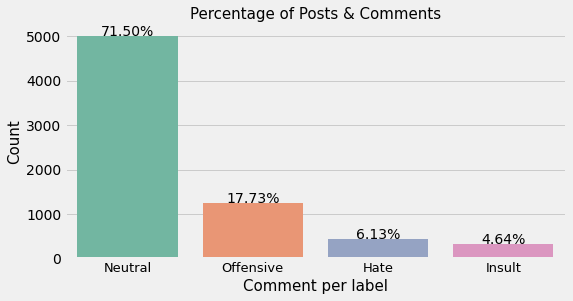

In [13]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(train_df['Class'], palette='Set2')

ax.set_title('Percentage of Posts & Comments',fontsize = 15)
ax.set_xlabel('Comment per label',fontsize = 15)
ax.set_ylabel('Count',fontsize = 15)
ax.set_xticklabels(['Neutral', 'Offensive','Hate', 'Insult'],fontsize = 13)

total = float(len(train_df)) 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total * 100) + '%',
            ha="center") 
fig.savefig('statistic.png', bbox_inches='tight',transparent=True, dpi=1000)

##Data Preprocessing

###Cleaning Text

In [14]:
def remove_special_chars(x):
	x = re.sub(r'[^\w\s ]+', " ", x)
  #x=re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', x)
	x=re.sub(r'([a-zA-Z0-9_.+-]+)@[a-zA-Z0-9_.+-]+\.[a-zA-Z0-9_.+-]', '', x)
	x = ' '.join(x.split())
	return x

In [15]:
#Cleaning the data
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = ps.cont_exp(x)
    x = ps.remove_emails(x)
    x = ps.remove_urls(x)
    x = ps.remove_html_tags(x)
    x = ps.remove_rt(x)
    x = remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    x=x.strip()
    return x
#call function to clean text Train dataset
#train_df['comment2']=train_df['comment'].apply(get_clean)
#test_df['comment2']=test_df['comment'].apply(get_clean)
#train_df.drop_duplicates(inplace=True)
#test_df.drop_duplicates(inplace=True)

In [16]:
#Cleaning the data
def cleaning_text(train_df, col):
    train_df[col] = train_df[col].apply(lambda x: re.sub(r'@[\S]+', ' ', str(x)))
    train_df[col] = train_df[col].apply(lambda x: re.sub(r'&[\S]+?;', ' ', str(x)))
    train_df[col] = train_df[col].apply(lambda x: re.sub(r'#', ' ', str(x)))
    train_df[col] = train_df[col].apply(lambda x: re.sub(r'http[\S]+', ' ', str(x)))
    train_df[col] = train_df[col].apply(lambda x: re.sub(r'[^\w\s]', r' ', str(x)))
    train_df[col] = train_df[col].apply(lambda x: " ".join(x.lower() for x in x.split()))
    train_df[col] = train_df[col].apply(lambda x: re.sub(r'\w*\d\w*', r' ', str(x)))
    train_df[col] = train_df[col].apply(lambda x: re.sub(r'\s\s+', ' ', str(x)))
    train_df[col] = train_df[col].apply(lambda x: re.sub(r'([a-zA-Z0-9_.+-]+)@[a-zA-Z0-9_.+-]+\.[a-zA-Z0-9_.+-]', '', str(x)))
    train_df[col]=train_df[col].apply(lambda x: re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', x))
    return train_df[col]
train_df['comment']=cleaning_text(train_df, 'comment')
test_df['comment']=cleaning_text(test_df, 'comment')
train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)

###Remove Stopwords

In [17]:
#Remove stopword
stopwords.words("french")
stopwords_ls = list(set(stopwords.words("french")))
rem_stop = re.compile(r"\b(" + "|".join(stopwords_ls) + ")\\W", re.I)
#################
def removeStopWords(sentence):
    global rem_stop
    return rem_stop.sub("", sentence)
train_df['comment'] = train_df['comment'].apply(removeStopWords)
test_df['comment'] = test_df['comment'].apply(removeStopWords)

In [18]:
train_df

,id,query_type,comment,Class,target,hate,offensive,Insult,Neutral
0,8,Facebook:/<page-id>/posts,dr djiddi ali sougoudi pourquoi regrette aucun...,normal,4,0,0,0,4
1,19,Facebook:/<page-id>/posts,dr djiddi ali sougoudi pourquoi regrette aucun...,offensive,2,0,2,0,0
2,23,Facebook:/<post-id>/comments,walay inal abouk zata,hate,1,1,0,0,0
3,38,Facebook:/<post-id>/comments,da bineye hana wene wa,normal,4,0,0,0,4
4,95,Facebook:/<post-id>/comments,dehors guilital adable,insult,3,0,0,3,0
...,...,...,...,...,...,...,...,...,...
6998,276748,Facebook:/<post-id>/comments,parle place feras mieux jette première pierre ...,normal,4,0,0,0,4
6999,299676,Facebook:/<post-id>/comments,grand doute ceux chantent tyran ans idriss deb...,offensive,2,0,2,0,0
7000,299682,Facebook:/<post-id>/comments,religieux enrôlés enseignants farine,normal,4,0,0,0,4
7001,299726,Facebook:/<post-id>/comments,censé attendre être emprisonné être vrais comb...,offensive,2,0,2,0,0


In [19]:
test_df

,id,comment
0,341,envie dire voisin femme trompe quelqu autre fa...
1,682,viande cheval vendue djamena dont âne petit ch...
2,1835,amine pluriel aminerrrrrrrr wehhhh souvent dis...
3,2335,amiss tchakkamna pini wa alyom moteur houmar g...
4,2336,oui bonjour famille jamais cru ndjamena nadif ...
...,...,...
6995,286551,si arrêter normal puisque marche a interdit au...
6996,287567,rectification hommes troubleurs bonnes urs dan...
6997,287759,abdel impression entrain marcher terrain gliss...
6998,289387,courage a union fait force cette manière voulo...


###Lemmatization

In [20]:
nlp=fr_core_news_md.load(disable=['ner', 'parser'])
def lem_text(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    txt=[w.strip() for w in txt]
    if len(txt) > 1:
        return ' '.join(txt)

In [21]:
t = time()
train_txt = [lem_text(doc) for doc in nlp.pipe(train_df['comment'], batch_size=5000, n_threads=-1)]
test_txt = [lem_text(doc) for doc in nlp.pipe(test_df['comment'], batch_size=5000, n_threads=-1)]
train_df['comment_text'] = pd.DataFrame({'comment_text': train_txt})
test_df['comment_text'] = pd.DataFrame({'comment_text':test_txt})
train_df['comment_text'] = train_df['comment_text'].dropna().drop_duplicates()
test_df['comment_text']=test_df['comment_text'].dropna().drop_duplicates()
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.4 mins


###Tokenization

In [22]:
#Words Tokenization
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    if set(tokens) not in list_stop: 
      return tokens
#train data
tokens=train_df['comment'].apply(lambda x: tokenize(str(x)))
train_df['tokens']=tokens
tokenslem=train_df['comment_text'].apply(lambda x: tokenize(str(x)))
train_df['tokens']=tokenslem
#test data
tokens2=test_df['comment'].apply(lambda x: tokenize(str(x)))
test_df['tokens']=tokens2
tokens2lem=test_df['comment_text'].apply(lambda x: tokenize(str(x)))
test_df['tokens']=tokens2lem

In [23]:
#Sentence Tokenization
def tokenize_s(text):
    tokens = nltk.sent_tokenize(text)
    if set(tokens) not in list_stop: 
      return tokens
#train data
tokens_s=train_df['comment'].apply(lambda x: tokenize_s(str(x)))
train_df['tokens_sent']=tokens_s
#test data
tokens2_s=test_df['comment'].apply(lambda x: tokenize_s(str(x)))
test_df['tokens_sent']=tokens2_s

In [24]:
#list_tokens=tokens.to_list()
#list_tokens2=tokens2.to_list()
list_tokens=tokenslem.to_list()
list_tokens2=tokens2lem.to_list()

###Save the data after preprcoessing

In [25]:
test_df.to_csv('test_preprocessed.csv', index=True, encoding='latin')
train_df.to_csv('train_preprocessed.csv',index=False, encoding='latin')

###Most frequent words

In [26]:
#Most frequent words train 
word_freq = defaultdict(int)
for sent in tokenslem:
    for i in sent:
        word_freq[i] += 1
print("Most frequent words train:",len(word_freq))
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

Most frequent words train: 11354


['deby',
 'tchad',
 'midi',
 'mouton',
 'tchadien',
 'pays',
 'faire',
 'président',
 'vouloir',
 'masra']

In [27]:
#Most frequent words test
word_freq2 = defaultdict(int)
for sent in tokens2lem:
    for i in sent:
        word_freq2[i] += 1
print("Most frequent words test:",len(word_freq2))
sorted(word_freq2, key=word_freq2.get, reverse=True)[:10]

Most frequent words test: 13228


['tchad',
 'tchadien',
 'pays',
 'faire',
 'falloir',
 'deby',
 'vouloir',
 'politique',
 'peuple',
 'président']

###Check missing values

In [28]:
print("missing value non-lemmatize:",train_df.comment.isnull().value_counts())
print("missing value after lemmatize:", train_df.comment_text.isnull().value_counts())

missing value non-lemmatize: False    7000
Name: comment, dtype: int64
missing value after lemmatize: False    6857
True      143
Name: comment_text, dtype: int64


In [29]:
print("missing value non-lemmatize",test_df.comment.isnull().value_counts())
print("missing value after lemmatize",test_df.comment_text.isnull().value_counts())

missing value non-lemmatize False    7000
Name: comment, dtype: int64
missing value after lemmatize False    6742
True      258
Name: comment_text, dtype: int64


###WordCloud for words per comment labelled

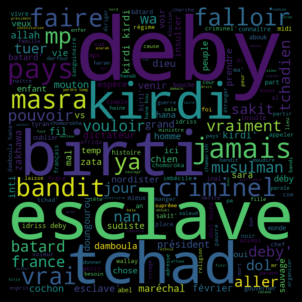

<Figure size 432x288 with 0 Axes>

In [31]:
#WordCloud for Hate comment
comments = train_df['comment_text'].loc[train_df['target']==1].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black', stopwords = list_stop).generate(str(comments))
fig = plt.figure(
    figsize = (8, 4),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
plt.savefig('hate.png', bbox_inches='tight',transparent=True, dpi=1000)

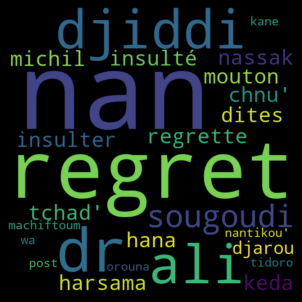

<Figure size 432x288 with 0 Axes>

In [32]:
#WordCloud for Offensive comment
comments = train_df['comment_text'].loc[train_df['target']==2].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black', stopwords = list_stop).generate(str(comments))
fig = plt.figure(
    figsize = (8, 4),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
plt.savefig('offensive.png', bbox_inches='tight',transparent=True, dpi=1000)

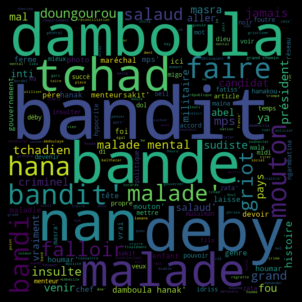

<Figure size 432x288 with 0 Axes>

In [33]:
#WordCloud for Insult comment
comments = train_df['comment_text'].loc[train_df['target']==3].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black', stopwords = list_stop).generate(str(comments))
fig = plt.figure(
    figsize = (8, 4),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
plt.savefig('insult.png', bbox_inches='tight',transparent=True, dpi=1000)

##Word Embedding Techniques

###Word2Vector Training model

In [34]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
#=======*****Train*****======
#Word2vec CBOW model train
cbow_model = Word2Vec(sg=0,min_count=2,window=5,size=300, workers=cores-1)
#Word2vec Skip-gram model train
skip_model = Word2Vec(sg=1,min_count=2,window=5,size=300, workers=cores-1)
#=======*****Test*****======
#Word2vec CBOW model test
ctest_model= Word2Vec(sg=0,min_count=2,window=5,size=300, workers=cores-1)
#Word2vec Skip-gram model test
stest_model = Word2Vec(sg=1,min_count=2,window=5,size=300, workers=cores-1)

In [35]:
#Build the vocabulary train
cbow_model.build_vocab(list_tokens, progress_per=10000)
skip_model.build_vocab(list_tokens, progress_per=10000)
#Build the vocabulary test
ctest_model.build_vocab(list_tokens2, progress_per=10000)
stest_model.build_vocab(list_tokens2, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 6.13 mins


In [36]:
#summarize vocabulary
corpus=list(cbow_model.wv.vocab)
#count rows
print(f"Total rows in Train corpus: {cbow_model.corpus_count}")
#total words
print(f"Total words in Train corpus: {cbow_model.corpus_total_words}")
#count rows
print(f"Total rows in Test corpus: {ctest_model.corpus_count}")
#total words
print(f"Total words in Test corpus: {ctest_model.corpus_total_words}")

Total rows in Train corpus: 7000
Total words in Train corpus: 56163
Total rows in Test corpus: 7000
Total words in Test corpus: 69370


In [37]:
#Train the model
cbow_model.train(list_tokens, total_examples=cbow_model.corpus_count, epochs=30, report_delay=1)
skip_model.train(list_tokens, total_examples=skip_model.corpus_count, epochs=30, report_delay=1)

#Test the model
ctest_model.train(list_tokens2, total_examples=ctest_model.corpus_count, epochs=30, report_delay=1)
stest_model.train(list_tokens2, total_examples=stest_model.corpus_count, epochs=30, report_delay=1)

print("Training a Gensim Word2Vec model complete")
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Training a Gensim Word2Vec model complete
Time to train the model: 6.74 mins


In [38]:
cbow_model.init_sims(replace=True)
skip_model.init_sims(replace=True)
ctest_model.init_sims(replace=True)
stest_model.init_sims(replace=True)

In [39]:
#most similarity
cbow_model.wv.most_similar(positive=["itno"])

[('idriss', 0.9769260883331299),
 ('déby', 0.9757811427116394),
 ('hinda', 0.970858633518219),
 ('dictateur', 0.9702277779579163),
 ('régime', 0.9523011445999146),
 ('dégager', 0.9283561706542969),
 ('vider', 0.9264758229255676),
 ('pauvreté', 0.9255871176719666),
 ('deby', 0.9128705263137817),
 ('président', 0.9043272733688354)]

In [40]:
skip_model.wv.most_similar(positive=["kouss"])

[('oumah', 0.8909772634506226),
 ('ra', 0.8883398175239563),
 ('oumak', 0.8835110664367676),
 ('ouma', 0.8815445899963379),
 ('kous', 0.8730666637420654),
 ('continu', 0.8646374940872192),
 ('daboula', 0.8599717020988464),
 ('sabour', 0.8566619157791138),
 ('fatiss', 0.8562473058700562),
 ('ajoute', 0.8458608388900757)]

In [41]:
#value of particular word
cbow_model.wv.__getitem__('unir')

array([-0.00672113, -0.12385748, -0.03545458,  0.00558404, -0.017057  ,
       -0.08231196, -0.0467416 , -0.04902085,  0.03284981,  0.02124452,
       -0.0136199 ,  0.02153306,  0.0202449 ,  0.02736886, -0.01136728,
        0.08316409,  0.02749131,  0.00476308, -0.00653243, -0.03885128,
        0.01331261,  0.03161994, -0.06966691, -0.05738469, -0.0950444 ,
        0.04640359, -0.06441415,  0.02123615,  0.08401969, -0.03075724,
       -0.02819682,  0.06518785, -0.01441434,  0.01261122,  0.15167293,
        0.10554668,  0.01503988,  0.00949597,  0.03020537, -0.0236107 ,
        0.07915916, -0.06497303,  0.0952222 , -0.03459486, -0.06792559,
        0.00443693, -0.06135015,  0.01713192, -0.04327172, -0.0828406 ,
       -0.01896158, -0.08461659, -0.00484772, -0.04759282, -0.02574969,
        0.09114475,  0.0303352 ,  0.04518731, -0.05497505, -0.10969713,
        0.00237788,  0.0250306 ,  0.02141082, -0.030743  ,  0.0970146 ,
        0.08413357,  0.0152586 , -0.01282481,  0.00398075, -0.06

In [42]:
#similarity between words
c=cbow_model.wv.similarity('hinda','déby')
print('CBOW:',c)
s=skip_model.wv.similarity('doungourou','mps')
print('Skip:',s)

CBOW: 0.961637
Skip: 0.47924492


In [43]:
#Vector CBOW datasets
def cbow_wv(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += cbow_model[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec
######
def skip_wv(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += skip_model[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec
######
tr_vw= np.zeros((len(list_tokens), 300))
ctr_wv=tr_vw
str_wv = tr_vw
ts_wv = np.zeros((len(list_tokens2), 300))
cts_wv=ts_wv
sts_wv=ts_wv

#Train shape
for i in range(len(list_tokens)):
    ctr_wv[i,:] = cbow_wv(list_tokens[i], 300)
    str_wv[i,:] = skip_wv(list_tokens[i], 300)
ctrain_wv = pd.DataFrame(ctr_wv)
strain_wv=pd.DataFrame(str_wv)
#Test shape
for i in range(len(list_tokens2)):
    cts_wv[i,:] = cbow_wv(list_tokens2[i], 300)
    sts_wv[i,:] = skip_wv(list_tokens2[i], 300)
ctest_wv = pd.DataFrame(cts_wv)
stest_wv=pd.DataFrame(sts_wv)
####
print('Shape train sets word2vec:',ctrain_wv.shape, strain_wv.shape)
print('Shape test sets word2vec:',ctest_wv.shape, stest_wv.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Shape train sets word2vec: (7000, 300) (7000, 300)
Shape test sets word2vec: (7000, 300) (7000, 300)


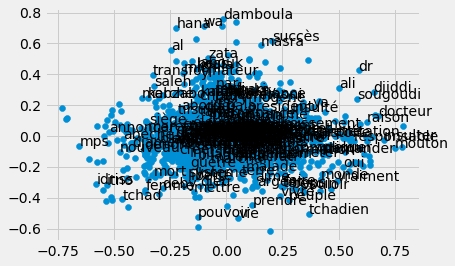

In [44]:
#visualization
X=cbow_model.wv.__getitem__(cbow_model.wv.vocab)
#create 2D model using PCA
pca_model=PCA(n_components=2)
result=pca_model.fit_transform(X)
#visualize
plt.scatter(result[:,0],result[:,1])
for i, word in enumerate(corpus[:200]):
  plt.annotate(s=word, xy=(result[i,0], result[i,1]))

plt.show()

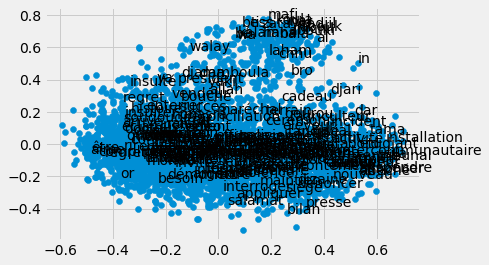

In [45]:
#visualization
X=skip_model.wv.__getitem__(skip_model.wv.vocab)
#create 2D model using PCA
pca_model=PCA(n_components=2)
result=pca_model.fit_transform(X)
#visualize
plt.scatter(result[:,0],result[:,1])
for i, word in enumerate(corpus[:200]):
  plt.annotate(s=word, xy=(result[i,0], result[i,1]))

plt.show()

###FastTest Training model

In [46]:
#FastText model
ftr_model=FastText(list_tokens,size=300, window=5, min_count=2)
fts_model=FastText(list_tokens2,size=300, window=5, min_count=2)
print("Training a Gensim FastText model complete")

Training a Gensim FastText model complete


In [47]:
#count rows
print(f"Total rows in Train corpus: {ftr_model.corpus_count}")
#total words
print(f"Total words in Train corpus: {ftr_model.corpus_total_words}")
#count rows
print(f"Total rows in Test corpus: {fts_model.corpus_count}")
#total words
print(f"Total words in Test corpus: {fts_model.corpus_total_words}")

Total rows in Train corpus: 7000
Total words in Train corpus: 56163
Total rows in Test corpus: 7000
Total words in Test corpus: 69370


In [48]:
ftr_model.most_similar(positive='itno')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('maréchal', 0.9999723434448242),
 ('recevoir', 0.9999720454216003),
 ('provoque', 0.9999719858169556),
 ('deby', 0.999971866607666),
 ('partir', 0.999971866607666),
 ('commerçant', 0.9999716877937317),
 ('percevoir', 0.9999715685844421),
 ('parti', 0.9999715089797974),
 ('souvenir', 0.9999713897705078),
 ('marchal', 0.9999713897705078)]

In [49]:
def word_vector(tokens, size):
     vec = np.zeros(size).reshape((1, size))
     count = 0.
     for word in tokens:
         try:
             vec += ftr_model[word].reshape((1, size))
             count += 1.
         except KeyError: # handling the case where the token is not in vocabulary
                         
             continue
     if count != 0:
         vec /= count
     return vec
fasttext_1 = np.zeros((len(list_tokens), 300))
fasttext_2 = np.zeros((len(list_tokens2), 300))

for i in range(len(list_tokens)):
     fasttext_1[i,:] = word_vector(list_tokens[i], 300)
for i in range(len(list_tokens2)):
     fasttext_2[i,:] = word_vector(list_tokens2[i], 300)
fasttext_train = pd.DataFrame(fasttext_1)
fasttext_test = pd.DataFrame(fasttext_2)
fasttext_train.shape, fasttext_test.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


((7000, 300), (7000, 300))

###Doc2vec Training model

In [50]:
#Tokenize the document
sp1=[TaggedDocument(doc,[i]) for i, doc in enumerate(list_tokens)]
sp2=[TaggedDocument(doc,[i]) for i, doc in enumerate(list_tokens2)]
#Define the model
d2vtr_model=Doc2Vec(vector_size=64, window=5, min_count=2, workers=8, epochs=40)
d2vts_model=Doc2Vec(vector_size=64, window=5, min_count=2, workers=8, epochs=40)
#Build vocabulary
d2vtr_model.build_vocab(sp1)
d2vts_model.build_vocab(sp2)
#Train the model
d2vtr_model.train(sp1, total_examples=d2vtr_model.corpus_count, epochs=d2vtr_model.epochs)
d2vts_model.train(sp2, total_examples=d2vts_model.corpus_count, epochs=d2vts_model.epochs)
print("Training a Gensim Doc2Vec model complete")

Training a Gensim Doc2Vec model complete


In [51]:
#generate vectors
d2vm=[d2vtr_model.infer_vector((list_tokens[i])) for i in range(0, len(list_tokens))]
#d2vm=[d2vtr_model.infer_vector((list_tokens[i].split(' '))) for i in range(0, len(list_tokens))]
doc2vec_train=np.array(d2vm)

##
d2vm1=[d2vts_model.infer_vector((list_tokens2[i])) for i in range(0, len(list_tokens2))]
doc2vec_test=np.array(d2vm1)

In [52]:
d2v_corpus=list(d2vtr_model.wv.vocab)
d2v_corpus2=list(d2vts_model.wv.vocab)
print(f'Total number of words:{d2v_corpus}')
#count rows
print(f"Total rows in corpus: {d2vtr_model.corpus_count}")
#total words
print(f"Total words in corpus: {d2vtr_model.corpus_total_words}")

Total number of words:['dr', 'djiddi', 'ali', 'sougoudi', 'regrette', 'regret', 'responsable', 'interprétation', 'tchad', 'insulté', 'insulter', 'mouton', 'dites', 'walay', 'inal', 'abouk', 'zata', 'hana', 'wa', 'mort', 'affrontement', 'salamat', 'nan', 'malade', 'mental', 'saleh', 'kebzabo', 'injustice', 'vivre', 'tchadien', 'yaki', 'tribune', 'restriction', 'efficace', 'être', 'michil', 'chnu', 'mafi', 'nar', 'koula', 'djari', 'idriss', 'deby', 'arrêter', 'faire', 'guerre', 'intercommunautaire', 'al', 'résolution', 'conflit', 'abéché', 'bouche', 'dirai', 'autorité', 'vouloir', 'poursuivre', 'justice', 'député', 'in', 'abouki', 'bala', 'radjil', 'ministère', 'jeuness', 'invité', 'succès', 'masra', 'cérémoni', 'installation', 'cnjt', 'continue', 'rêver', 'vendeur', 'or', 'bess', 'yi', 'aime', 'argent', 'interroger', 'temps', 'pouvoir', 'mettre', 'terre', 'enterrer', 'ya', 'djama', 'damboula', 'ti', 'bé', 'dizaine', 'blessé', 'violence', 'dar', 'tama', 'système', 'appliquer', 'bro', 'me

In [53]:
#most similarity
d2vtr_model.wv.most_similar("deby")

[('déby', 0.8594287633895874),
 ('itno', 0.8128180503845215),
 ('hinda', 0.7984415292739868),
 ('pauvreté', 0.7897909283638),
 ('tyran', 0.7894355058670044),
 ('dictateur', 0.7892800569534302),
 ('nation', 0.7782888412475586),
 ('sanguinaire', 0.7704161405563354),
 ('dictatorial', 0.7701829671859741),
 ('dégager', 0.7620078325271606)]

In [54]:
d2vtr_model.most_similar(positive='kirdi')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('sakite', 0.9069944620132446),
 ('épouse', 0.8725579977035522),
 ('sara', 0.8625037670135498),
 ('yoskou', 0.8496319651603699),
 ('arabe', 0.8432186841964722),
 ('sakit', 0.8376469016075134),
 ('olo', 0.8360357284545898),
 ('birti', 0.8237817883491516),
 ('doum', 0.8054302930831909),
 ('gouverner', 0.8011745810508728)]

##Splitting the data Train & Test

In [55]:
#Splitting the data to Train and Test
from sklearn.model_selection import train_test_split, cross_val_score
y_target=train_df['target']
#Using Skip-gram model train
X_train1,X_test1, y_train1, y_test1 = train_test_split(strain_wv, y_target, test_size=0.25, random_state=42, stratify=y_target)
#Using CBOW model train
X_train0,X_test0, y_train0, y_test0 = train_test_split(ctrain_wv, y_target, test_size=0.25, random_state=42, stratify=y_target)
#Using Doc2vec model train
train_X,test_X, train_y, test_y = train_test_split(doc2vec_train, y_target, test_size=0.25, random_state=42, stratify=y_target)
#Using FastText model train & test
Xtrain,Xtest, ytrain, ytest = train_test_split(fasttext_train, y_target, test_size=0.25, random_state=42, stratify=y_target)

In [56]:
cols_target=['hate', 'offensive','Insult', 'Neutral']
#****Word2vec**********
# Using CBOW model train/test
X_ctrain=ctrain_wv
#y_ctrain=train_df['target']
X_ctest=ctest_wv
#y_ctest will be model.predict(X_ctest)
# Usinf Skip gram model train/test
X_strain=strain_wv
#y_strain=train_df['target']
X_stest=stest_wv
#y_stest will be model.predict(X_ctest)
# Doc2vec model
traind_X=doc2vec_train
testd_X=doc2vec_test
#FastText model
Xtrainf=fasttext_train
Xtestf=fasttext_test

##Machine Learning Classification

###Scikit-learn Libraries

In [57]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,recall_score,precision_score, ConfusionMatrixDisplay, f1_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import svm

In [58]:
result_cbow=pd.read_csv('result_test.csv', encoding='latin')
result_skip=pd.read_csv('result_test.csv', encoding='latin')
result_dov2vec=pd.read_csv('result_test.csv', encoding='latin')
result_fasttext=pd.read_csv('result_test.csv', encoding='latin')

###Logistic Regression

In [59]:
#Logistic classifier train sets split using word2vec, FastText, Doc2vec
lrc = LogisticRegression(solver='liblinear',multi_class='ovr', max_iter=1000)
lrs = LogisticRegression(solver='liblinear',multi_class='ovr', max_iter=1000)
lrd = LogisticRegression(solver='liblinear',multi_class='ovr', max_iter=1000)
lrf = LogisticRegression(solver='liblinear',multi_class='ovr', max_iter=1000)
#fit the model
lrc.fit(X_train0, y_train0) #CBOW
lrs.fit(X_train1, y_train1) #Skip
lrd.fit(train_X, train_y) #Doc2vec
lrf.fit(Xtrain, ytrain) #FastText
#make prediction
lrc_pred=lrc.predict(X_test0)
lrs_pred=lrs.predict(X_test1)
lrd_pred=lrd.predict(test_X)
lrf_pred=lrf.predict(Xtest)
print(f"Accuracy CBOW: {lrc.score(X_test0, y_test0)*100:.3f}%\nAccuracy Skip: {lrs.score(X_test1, y_test1)*100:.3f}%\nAccuracy Dov2Vec: {lrd.score(test_X, test_y)*100:.3f}%\nAccuracy Fasttext: {lrf.score(Xtest, ytest)*100:.3f}%\n")
print("CBOW:", classification_report(lrc_pred, y_test0),'\n')
print("Skip:", classification_report(lrs_pred, y_test1),'\n')
print("Doc2vec:", classification_report(lrd_pred, test_y),'\n')
print("FastText:", classification_report(lrf_pred, ytest),'\n')

Accuracy CBOW: 73.029%
Accuracy Skip: 73.029%
Accuracy Dov2Vec: 72.857%
Accuracy Fasttext: 71.543%

CBOW:               precision    recall  f1-score   support

           1       0.23      0.76      0.36        33
           2       0.03      0.17      0.04        48
           3       0.20      0.73      0.31        22
           4       0.98      0.75      0.85      1647

    accuracy                           0.73      1750
   macro avg       0.36      0.60      0.39      1750
weighted avg       0.93      0.73      0.81      1750
 

Skip:               precision    recall  f1-score   support

           1       0.23      0.76      0.36        33
           2       0.03      0.17      0.04        48
           3       0.20      0.73      0.31        22
           4       0.98      0.75      0.85      1647

    accuracy                           0.73      1750
   macro avg       0.36      0.60      0.39      1750
weighted avg       0.93      0.73      0.81      1750
 

Doc2vec:      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
print('precision:',precision_score(ytest, lrf_pred, average='micro'))
print('recall:', recall_score(ytest, lrf_pred, average='micro'))
print('f1_score:',f1_score(ytest, lrf_pred, average='micro'))
print('accuracy:',accuracy_score(ytest, lrf_pred, normalize=True))

precision: 0.7154285714285714
recall: 0.7154285714285714
f1_score: 0.7154285714285715
accuracy: 0.7154285714285714


In [61]:
#Logistic classifier train & test sets using word2vec, FastText, Doc2vec
for label in cols_target:
    print('... Processing {}'.format(label))
    y = train_df[label]
    # train the model using X_train & y_train
    lrc.fit(X_ctrain, y) #CBOW
    lrs.fit(X_strain, y) #Skip
    lrd.fit(traind_X, y) #Doc2vec
    lrf.fit(Xtrainf, y) #FastText
    # Generate predicted labels accuracy
    y_cpred_X = lrc.predict(X_ctest)
    y_spred_X = lrs.predict(X_stest)
    y_dpred_X = lrd.predict(testd_X)
    y_fpred_X = lrf.predict(Xtestf)
    print('Training CBOW accuracy is {}'.format(accuracy_score(y, y_cpred_X)),'\nTraining Skip accuracy is {}'.format(accuracy_score(y, y_spred_X)),'\nTraining Doc2vec accuracy is {}'.format(accuracy_score(y, y_dpred_X)),'\nTraining FastText accuracy is {}\n'.format(accuracy_score(y, y_fpred_X)))
    # Generate predicted probabilities for labels
    test_y_probc = lrc.predict_proba(X_ctest)[:,1]
    test_y_probs = lrs.predict_proba(X_stest)[:,1]
    test_y_probd = lrd.predict_proba(testd_X)[:,1]
    test_y_probf = lrf.predict_proba(Xtestf)[:,1]
    
   #Save the result to file
    result_cbow[label] = test_y_probc
    result_skip[label] = test_y_probs
    result_dov2vec[label] = test_y_probd
    result_fasttext[label] = test_y_probf
result_cbow.to_csv('cbow_LR.csv',index=False, encoding='latin')
result_skip.to_csv('skip_LR.csv',index=False, encoding='latin')
result_dov2vec.to_csv('doc2vec_LR.csv',index=False, encoding='latin')
result_fasttext.to_csv('fasttext_LR.csv',index=False, encoding='latin')

... Processing hate
Training CBOW accuracy is 0.9331428571428572 
Training Skip accuracy is 0.9331428571428572 
Training Doc2vec accuracy is 0.9344285714285714 
Training FastText accuracy is 0.939

... Processing offensive
Training CBOW accuracy is 0.8164285714285714 
Training Skip accuracy is 0.8164285714285714 
Training Doc2vec accuracy is 0.8105714285714286 
Training FastText accuracy is 0.8227142857142857

... Processing Insult
Training CBOW accuracy is 0.9514285714285714 
Training Skip accuracy is 0.9514285714285714 
Training Doc2vec accuracy is 0.9494285714285714 
Training FastText accuracy is 0.9535714285714286

... Processing Neutral
Training CBOW accuracy is 0.64 
Training Skip accuracy is 0.64 
Training Doc2vec accuracy is 0.677 
Training FastText accuracy is 0.7152857142857143



####Confusion matrix

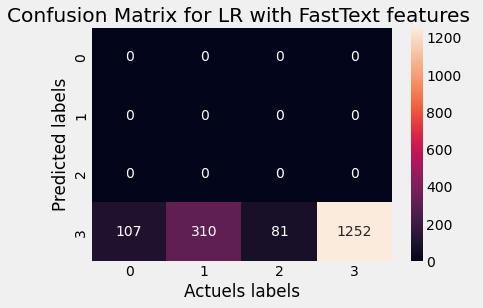

In [62]:
ax= plt.subplot()
cm=confusion_matrix(ytest, lrf_pred)
sns.heatmap(cm.T, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Actuels labels');ax.set_ylabel('Predicted labels'); 
ax.set_title('Confusion Matrix for LR with FastText features '); 
plt.savefig('lr_cfmatrix.png', bbox_inches='tight',transparent=True, dpi=1000)

###Support vector machine

In [63]:
#Support Vector Machine classifier train sets split using word2vec, FastText, Doc2vec
csvm = svm.SVC(kernel='linear', probability=True) # We set a SVM classifier, the default SVM Classifier (Kernel = Radial Basis Function)
svms = svm.SVC(kernel='linear',probability=True)
dsvm = svm.SVC(kernel='linear',probability=True)
fsvm = svm.SVC(kernel='linear',probability=True)
#fit the model
csvm.fit(X_train0, y_train0) #CBOW
svms.fit(X_train1, y_train1) #Skip
dsvm.fit(train_X, train_y) #Doc2vec
fsvm.fit(Xtrain, ytrain) #FastText
#make prediction
csvm_pred=csvm.predict(X_test0)
svms_pred=svms.predict(X_test1)
dsvm_pred=dsvm.predict(test_X)
fsvm_pred=fsvm.predict(Xtest)
print(f"Accuracy CBOW: {csvm.score(X_test0, y_test0)*100:.3f}%\nAccuracy Skip: {svms.score(X_test1, y_test1)*100:.3f}%\nAccuracy Dov2Vec: {dsvm.score(test_X, test_y)*100:.3f}%\nAccuracy Fasttext: {fsvm.score(Xtest, ytest)*100:.3f}%\n")
print("CBOW:", classification_report(csvm_pred, y_test0),'\n')
print("Skip:", classification_report(svms_pred, y_test1),'\n')
print("Doc2vec:", classification_report(dsvm_pred, test_y),'\n')
print("FastText:", classification_report(fsvm_pred, ytest),'\n')

Accuracy CBOW: 72.514%
Accuracy Skip: 72.514%
Accuracy Dov2Vec: 71.543%
Accuracy Fasttext: 71.543%

CBOW:               precision    recall  f1-score   support

           1       0.12      0.81      0.21        16
           2       0.00      0.00      0.00         2
           3       0.07      0.60      0.13        10
           4       1.00      0.73      0.84      1722

    accuracy                           0.73      1750
   macro avg       0.30      0.53      0.30      1750
weighted avg       0.98      0.73      0.83      1750
 

Skip:               precision    recall  f1-score   support

           1       0.12      0.81      0.21        16
           2       0.00      0.00      0.00         2
           3       0.07      0.60      0.13        10
           4       1.00      0.73      0.84      1722

    accuracy                           0.73      1750
   macro avg       0.30      0.53      0.30      1750
weighted avg       0.98      0.73      0.83      1750
 

Doc2vec:      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
print('precision:',precision_score(ytest, fsvm_pred, average='micro'))
print('recall:', recall_score(ytest, fsvm_pred, average='micro'))
print('f1_score:',f1_score(ytest, fsvm_pred, average='micro'))
print('accuracy:',accuracy_score(ytest, fsvm_pred, normalize=True))

precision: 0.7154285714285714
recall: 0.7154285714285714
f1_score: 0.7154285714285715
accuracy: 0.7154285714285714


In [65]:
#Support Vector Machine classifier train sets split using word2vec, FastText, Doc2vec

for label in cols_target:
    print('... Processing {}'.format(label))
    y = train_df[label]
    # train the model using X_train & y_train
    csvm.fit(X_ctrain, y) #CBOW
    svms.fit(X_strain, y) #Skip
    dsvm.fit(traind_X, y) #Doc2vec
    fsvm.fit(Xtrainf, y) #FastText
    # Generate predicted labels accuracy
    y_cpred_X = csvm.predict(X_ctest)
    y_spred_X = svms.predict(X_stest)
    y_dpred_X = dsvm.predict(testd_X)
    y_fpred_X = fsvm.predict(Xtestf)
    print('Training CBOW accuracy is {}'.format(accuracy_score(y, y_cpred_X)),'\nTraining Skip accuracy is {}'.format(accuracy_score(y, y_spred_X)),'\nTraining Doc2vec accuracy is {}'.format(accuracy_score(y, y_dpred_X)),'\nTraining FastText accuracy is {}\n'.format(accuracy_score(y, y_fpred_X)))
    # Generate predicted probabilities for labels
    test_y_probc = csvm.predict_proba(X_ctest)[:,1]
    test_y_probs = svms.predict_proba(X_stest)[:,1]
    test_y_probd = dsvm.predict_proba(testd_X)[:,1]
    test_y_probf = fsvm.predict_proba(Xtestf)[:,1]
    
   #Save the result to file
    result_cbow[label] = test_y_probc
    result_skip[label] = test_y_probs
    result_dov2vec[label] = test_y_probd
    result_fasttext[label] = test_y_probf
result_cbow.to_csv('cbow_SVM.csv',index=False, encoding='latin')
result_skip.to_csv('skip_SVM.csv',index=False, encoding='latin')
result_dov2vec.to_csv('doc2vec_SVM.csv',index=False, encoding='latin')
result_fasttext.to_csv('fasttext_SVM.csv',index=False, encoding='latin')

... Processing hate
Training CBOW accuracy is 0.9388571428571428 
Training Skip accuracy is 0.9388571428571428 
Training Doc2vec accuracy is 0.9388571428571428 
Training FastText accuracy is 0.9388571428571428

... Processing offensive
Training CBOW accuracy is 0.8227142857142857 
Training Skip accuracy is 0.8227142857142857 
Training Doc2vec accuracy is 0.8227142857142857 
Training FastText accuracy is 0.8227142857142857

... Processing Insult
Training CBOW accuracy is 0.9535714285714286 
Training Skip accuracy is 0.9535714285714286 
Training Doc2vec accuracy is 0.9535714285714286 
Training FastText accuracy is 0.9535714285714286

... Processing Neutral
Training CBOW accuracy is 0.6484285714285715 
Training Skip accuracy is 0.6484285714285715 
Training Doc2vec accuracy is 0.6627142857142857 
Training FastText accuracy is 0.7151428571428572



####Confusion matrix

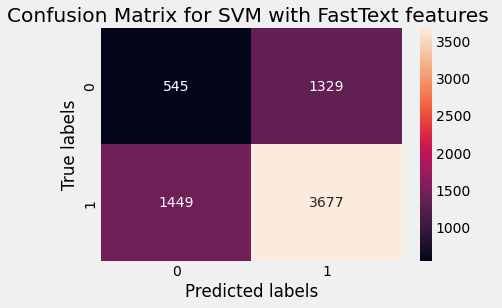

In [75]:
ax= plt.subplot()
cm=confusion_matrix(y, y_cpred_X)
sns.heatmap(cm.T, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for SVM with FastText features '); 
plt.savefig('svmf_cfmatrix.png', bbox_inches='tight',transparent=True, dpi=1000)

###Random Forest

In [67]:
#Random Forest classifier train sets split using word2vec, FastText, Doc2vec
crf=RandomForestClassifier(n_estimators=40, max_leaf_nodes=500)
srf=RandomForestClassifier(n_estimators=40, max_leaf_nodes=500)
drf=RandomForestClassifier(n_estimators=40, max_leaf_nodes=500)
frf=RandomForestClassifier(n_estimators=40, max_leaf_nodes=500)
#fit the model
crf.fit(X_train0, y_train0) #CBOW
srf.fit(X_train1, y_train1) #Skip
drf.fit(train_X, train_y) #Doc2vec
frf.fit(Xtrain, ytrain) #FastText
#make prediction
crf_pred=crf.predict(X_test0)
srf_pred=srf.predict(X_test1)
drf_pred=drf.predict(test_X)
frf_pred=frf.predict(Xtest)
print(f"Accuracy CBOW: {crf.score(X_test0, y_test0)*100:.3f}%\nAccuracy Skip: {srf.score(X_test1, y_test1)*100:.3f}%\nAccuracy Dov2Vec: {drf.score(test_X, test_y)*100:.3f}%\nAccuracy Fasttext: {frf.score(Xtest, ytest)*100:.3f}%\n")
print("CBOW:", classification_report(crf_pred, y_test0),'\n')
print("Skip:", classification_report(srf_pred, y_test1),'\n')
print("Doc2vec:", classification_report(drf_pred, test_y),'\n')
print("FastText:", classification_report(frf_pred, ytest),'\n')

Accuracy CBOW: 73.657%
Accuracy Skip: 73.714%
Accuracy Dov2Vec: 72.800%
Accuracy Fasttext: 71.486%

CBOW:               precision    recall  f1-score   support

           1       0.26      0.72      0.38        39
           2       0.06      0.32      0.10        59
           3       0.22      0.69      0.34        26
           4       0.98      0.75      0.85      1626

    accuracy                           0.74      1750
   macro avg       0.38      0.62      0.42      1750
weighted avg       0.92      0.74      0.81      1750
 

Skip:               precision    recall  f1-score   support

           1       0.23      0.76      0.36        33
           2       0.09      0.35      0.15        83
           3       0.22      0.60      0.32        30
           4       0.97      0.76      0.85      1604

    accuracy                           0.74      1750
   macro avg       0.38      0.62      0.42      1750
weighted avg       0.90      0.74      0.80      1750
 

Doc2vec:      

In [68]:
print('precision:',precision_score(y_test1, srf_pred, average='micro'))
print('recall:', recall_score(y_test1, srf_pred, average='micro'))
print('f1_score:',f1_score(y_test1, srf_pred, average='micro'))
print('accuracy:',accuracy_score(y_test1, srf_pred, normalize=True))

precision: 0.7371428571428571
recall: 0.7371428571428571
f1_score: 0.7371428571428572
accuracy: 0.7371428571428571


In [69]:
#Random Forest classifier train sets split using word2vec, FastText, Doc2vec

for label in cols_target:
    print('... Processing {}'.format(label))
    y = train_df[label]
    # train the model using X_train & y_train
    crf.fit(X_ctrain, y) #CBOW
    srf.fit(X_strain, y) #Skip
    drf.fit(traind_X, y) #Doc2vec
    frf.fit(Xtrainf, y) #FastText
    # Generate predicted labels accuracy
    y_cpred_X = crf.predict(X_ctest)
    y_spred_X = srf.predict(X_stest)
    y_dpred_X = drf.predict(testd_X)
    y_fpred_X = frf.predict(Xtestf)
    print('Training CBOW accuracy is {}'.format(accuracy_score(y, y_cpred_X)),'\nTraining Skip accuracy is {}'.format(accuracy_score(y, y_spred_X)),'\nTraining Doc2vec accuracy is {}'.format(accuracy_score(y, y_dpred_X)),'\nTraining FastText accuracy is {}\n'.format(accuracy_score(y, y_fpred_X)))
    # Generate predicted probabilities for labels
    test_y_probc = crf.predict_proba(X_ctest)[:,1]
    test_y_probs = srf.predict_proba(X_stest)[:,1]
    test_y_probd = drf.predict_proba(testd_X)[:,1]
    test_y_probf = frf.predict_proba(Xtestf)[:,1]
    
   #Save the result to file
    result_cbow[label] = test_y_probc
    result_skip[label] = test_y_probs
    result_dov2vec[label] = test_y_probd
    result_fasttext[label] = test_y_probf
result_cbow.to_csv('cbow_RF.csv',index=False, encoding='latin')
result_skip.to_csv('skip_RF.csv',index=False, encoding='latin')
result_dov2vec.to_csv('doc2vec_RF.csv',index=False, encoding='latin')
result_fasttext.to_csv('fasttext_RF.csv',index=False, encoding='latin')

... Processing hate
Training CBOW accuracy is 0.9232857142857143 
Training Skip accuracy is 0.9227142857142857 
Training Doc2vec accuracy is 0.9371428571428572 
Training FastText accuracy is 0.9245714285714286

... Processing offensive
Training CBOW accuracy is 0.7935714285714286 
Training Skip accuracy is 0.7932857142857143 
Training Doc2vec accuracy is 0.7902857142857143 
Training FastText accuracy is 0.8054285714285714

... Processing Insult
Training CBOW accuracy is 0.937 
Training Skip accuracy is 0.9382857142857143 
Training Doc2vec accuracy is 0.9534285714285714 
Training FastText accuracy is 0.9401428571428572

... Processing Neutral
Training CBOW accuracy is 0.628 
Training Skip accuracy is 0.631 
Training Doc2vec accuracy is 0.6851428571428572 
Training FastText accuracy is 0.6712857142857143



####Confusion matrix

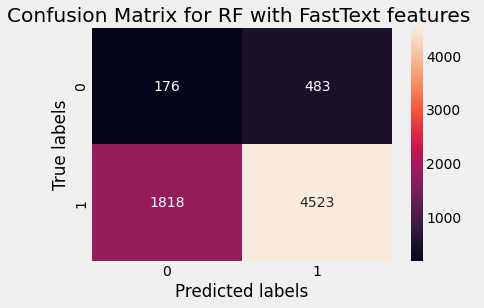

In [70]:
ax= plt.subplot()
cm=confusion_matrix(y, y_fpred_X)
sns.heatmap(cm.T, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for RF with FastText features '); 
#ax.xaxis.set_ticklabels(['Neutral', 'Offensive','Hate', 'Insult']); ax.yaxis.set_ticklabels(['Insult', 'Hate', 'Offensive', 'Neutral']);
plt.savefig('svmf_cfmatrix.png', bbox_inches='tight',transparent=True, dpi=1000)

###Extreme Gradiant Boosting

In [71]:
#Extreme Gradiant Boosting classifier train sets split using word2vec, FastText, Doc2vec
cxgbc=XGBClassifier(use_label_encoder =False,eval_metric='logloss',objective ="binary:logistic",learning_rate =0.1,n_estimators=1000,max_depth=5)
sxgbc=XGBClassifier(use_label_encoder =False,eval_metric='logloss',objective ="binary:logistic",learning_rate =0.1,n_estimators=1000,max_depth=5)
dxgbc=XGBClassifier(use_label_encoder =False,eval_metric='logloss',objective ="binary:logistic",learning_rate =0.1,n_estimators=1000,max_depth=5)
fxgbc=XGBClassifier(use_label_encoder =False,eval_metric='logloss',objective ="binary:logistic",learning_rate =0.1,n_estimators=1000,max_depth=5)
# Fit the model
cxgbc.fit(X_train0, y_train0) #CBOW
sxgbc.fit(X_train1, y_train1) #Skip
dxgbc.fit(train_X, train_y) #Doc2vec
fxgbc.fit(Xtrain, ytrain) #FastText
#make prediction
cxgbc_pred=cxgbc.predict(X_test0)
sxgbc_pred=sxgbc.predict(X_test1)
dxgbc_pred=dxgbc.predict(test_X)
fxgbc_pred=fxgbc.predict(Xtest)
print(f"Accuracy CBOW: {cxgbc.score(X_test0, y_test0)*100:.3f}%\nAccuracy Skip: {sxgbc.score(X_test1, y_test1)*100:.3f}%\nAccuracy Dov2Vec: {dxgbc.score(test_X, test_y)*100:.3f}%\nAccuracy Fasttext: {fxgbc.score(Xtest, ytest)*100:.3f}%\n")
print("CBOW:", classification_report(cxgbc_pred, y_test0),'\n')
print("Skip:", classification_report(sxgbc_pred, y_test1),'\n')
print("Doc2vec:", classification_report(dxgbc_pred, test_y),'\n')
print("FastText:", classification_report(fxgbc_pred, ytest),'\n')

Accuracy CBOW: 74.800%
Accuracy Skip: 74.800%
Accuracy Dov2Vec: 73.771%
Accuracy Fasttext: 70.171%

CBOW:               precision    recall  f1-score   support

           1       0.31      0.72      0.43        46
           2       0.19      0.41      0.26       140
           3       0.28      0.64      0.39        36
           4       0.95      0.78      0.86      1528

    accuracy                           0.75      1750
   macro avg       0.43      0.64      0.49      1750
weighted avg       0.86      0.75      0.79      1750
 

Skip:               precision    recall  f1-score   support

           1       0.31      0.72      0.43        46
           2       0.19      0.41      0.26       140
           3       0.28      0.64      0.39        36
           4       0.95      0.78      0.86      1528

    accuracy                           0.75      1750
   macro avg       0.43      0.64      0.49      1750
weighted avg       0.86      0.75      0.79      1750
 

Doc2vec:      

In [72]:
print('precision:',precision_score(test_y, dxgbc_pred, average='micro'))
print('recall:', recall_score(test_y, dxgbc_pred, average='micro'))
print('f1_score:',f1_score(test_y, dxgbc_pred, average='micro'))
print('accuracy:',accuracy_score(test_y, dxgbc_pred, normalize=True))

precision: 0.7377142857142858
recall: 0.7377142857142858
f1_score: 0.7377142857142858
accuracy: 0.7377142857142858


In [73]:
#Extreme Gradiant Boosting classifier train sets split using word2vec, FastText, Doc2vec

cxgbc=XGBClassifier(use_label_encoder =False,eval_metric='logloss',objective ="binary:logistic",learning_rate =0.1,n_estimators=1000,max_depth=5)
sxgbc=XGBClassifier(use_label_encoder =False,eval_metric='logloss',objective ="binary:logistic",learning_rate =0.1,n_estimators=1000,max_depth=5)
dxgbc=XGBClassifier(use_label_encoder =False,eval_metric='logloss',objective ="binary:logistic",learning_rate =0.1,n_estimators=1000,max_depth=5)
fxgbc=XGBClassifier(use_label_encoder =False,eval_metric='logloss',objective ="binary:logistic",learning_rate =0.1,n_estimators=1000,max_depth=5)
for label in cols_target:
    print('... Processing {}'.format(label))
    y = train_df[label]
    # train the model using X_train & y_train
    cxgbc.fit(X_ctrain, y) #CBOW
    sxgbc.fit(X_strain, y) #Skip
    dxgbc.fit(traind_X, y) #Doc2vec
    fxgbc.fit(Xtrainf, y) #FastText
    # Generate predicted labels accuracy
    y_cpred_X = cxgbc.predict(X_ctest)
    y_spred_X = sxgbc.predict(X_stest)
    y_dpred_X = dxgbc.predict(testd_X)
    y_fpred_X = fxgbc.predict(Xtestf)
    print('Training CBOW accuracy is {}'.format(accuracy_score(y, y_cpred_X)),'\nTraining Skip accuracy is {}'.format(accuracy_score(y, y_spred_X)),'\nTraining Doc2vec accuracy is {}'.format(accuracy_score(y, y_dpred_X)),'\nTraining FastText accuracy is {}\n'.format(accuracy_score(y, y_fpred_X)))
    # Generate predicted probabilities for labels
    test_y_probc = cxgbc.predict_proba(X_ctest)[:,1]
    test_y_probs = sxgbc.predict_proba(X_stest)[:,1]
    test_y_probd = dxgbc.predict_proba(testd_X)[:,1]
    test_y_probf = fxgbc.predict_proba(Xtestf)[:,1]
    
   #Save the result to file
    result_cbow[label] = test_y_probc
    result_skip[label] = test_y_probs
    result_dov2vec[label] = test_y_probd
    result_fasttext[label] = test_y_probf
result_cbow.to_csv('cbow_XGBC.csv',index=False, encoding='latin')
result_skip.to_csv('skip_XGBC.csv',index=False, encoding='latin')
result_dov2vec.to_csv('doc2vec_XGBC.csv',index=False, encoding='latin')
result_fasttext.to_csv('fasttext_XGBC.csv',index=False, encoding='latin')

... Processing hate
Training CBOW accuracy is 0.9235714285714286 
Training Skip accuracy is 0.9235714285714286 
Training Doc2vec accuracy is 0.9377142857142857 
Training FastText accuracy is 0.9212857142857143

... Processing offensive
Training CBOW accuracy is 0.761 
Training Skip accuracy is 0.761 
Training Doc2vec accuracy is 0.8107142857142857 
Training FastText accuracy is 0.7922857142857143

... Processing Insult
Training CBOW accuracy is 0.9394285714285714 
Training Skip accuracy is 0.9394285714285714 
Training Doc2vec accuracy is 0.9532857142857143 
Training FastText accuracy is 0.9387142857142857

... Processing Neutral
Training CBOW accuracy is 0.6031428571428571 
Training Skip accuracy is 0.6031428571428571 
Training Doc2vec accuracy is 0.6734285714285714 
Training FastText accuracy is 0.6497142857142857



####Confusion Matrix

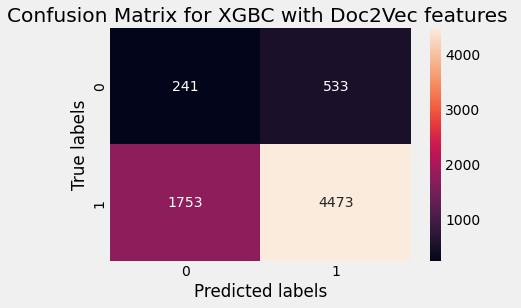

In [74]:
ax= plt.subplot()
cm=confusion_matrix(y, y_dpred_X)
sns.heatmap(cm.T, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for XGBC with Doc2Vec features '); 
plt.savefig('svmf_cfmatrix.png', bbox_inches='tight',transparent=True, dpi=1000)